In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve,roc_curve,confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier, plot_importance


In [2]:
# Cargar y limpiar
titanic = sns.load_dataset("titanic").dropna(subset=['age', 'embarked', 'fare'])
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'S': 0, 'C': 1, 'Q': 2})
X = titanic[['pclass', 'sex', 'age', 'fare', 'embarked']]
y = titanic['survived']

In [3]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


In [4]:
# Hiperparámetros
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.7, 0.9, 1],
    "colsample_bytree": [0.7, 0.8, 1],
}

In [5]:
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)
search_clf = RandomizedSearchCV(xgb_clf, param_dist, n_iter=10, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
search_clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.7, 0.9, 1]},
                   scoring='roc_auc', verbose=1)

In [6]:
best_clf = search_clf.best_estimator_
y_proba = best_clf.predict_proba(X_test)[:, 1]

In [7]:
# --- 5. Evaluación AUC global ---
print(f"\n✅ AUC (usando y_proba): {roc_auc_score(y_test, y_proba):.3f}")



✅ AUC (usando y_proba): 0.840


![Descripción de la imagen](f1score.png)

In [8]:
# --- 6. F1 Score por cuantiles ---
df_eval = pd.DataFrame({'true': y_test, 'proba': y_proba})
thresholds = np.quantile(df_eval['proba'], np.linspace(0.1, 0.9, 9))
scores = []

for t in thresholds:
    pred = (df_eval['proba'] >= t).astype(int)
    f1 = f1_score(df_eval['true'], pred)
    scores.append((t, f1))

print("\n📊 --- F1 Score por punto de corte (cuantiles) ---")
for t, f1 in scores:
    print(f"Threshold: {t:.2f} | F1 Score: {f1:.3f}")


📊 --- F1 Score por punto de corte (cuantiles) ---
Threshold: 0.04 | F1 Score: 0.595
Threshold: 0.09 | F1 Score: 0.626
Threshold: 0.13 | F1 Score: 0.663
Threshold: 0.18 | F1 Score: 0.704
Threshold: 0.27 | F1 Score: 0.758
Threshold: 0.50 | F1 Score: 0.727
Threshold: 0.65 | F1 Score: 0.683
Threshold: 0.83 | F1 Score: 0.593
Threshold: 0.93 | F1 Score: 0.378


In [9]:
# --- 7. Mejor threshold basado en F1 ---
best_threshold = max(scores, key=lambda x: x[1])[0]
y_pred = (y_proba >= best_threshold).astype(int)
print(f"\n⭐ Mejor punto de corte (F1): {best_threshold:.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"AUC (de nuevo con proba): {roc_auc_score(y_test, y_proba):.3f}")



⭐ Mejor punto de corte (F1): 0.27
F1 Score: 0.758
AUC (de nuevo con proba): 0.840


In [17]:
y_pred=(y_proba>0.27).astype(int)

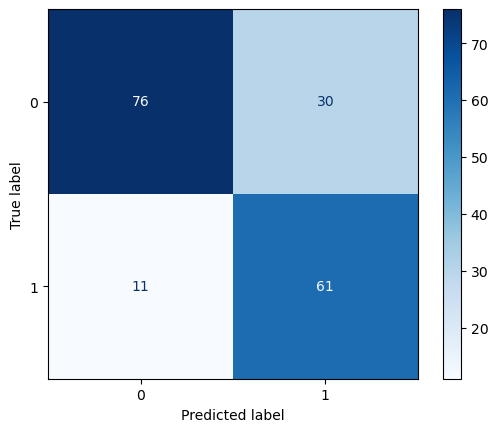

In [18]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.show()

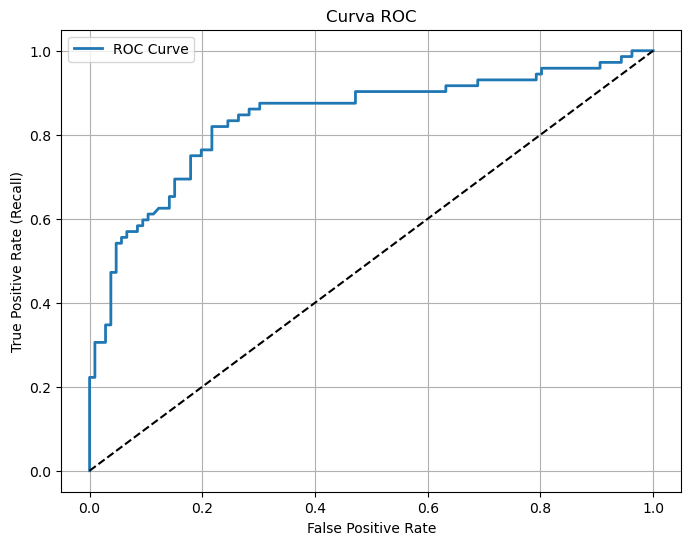

In [19]:
# --- 8. Curva ROC ---
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

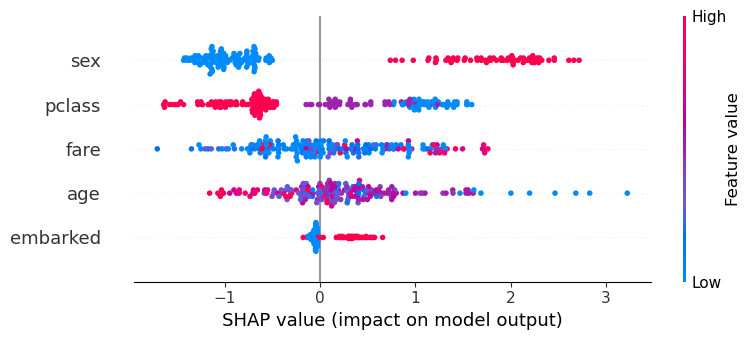

In [13]:
# --- 10. Interpretación SHAP ---
explainer = shap.Explainer(best_clf, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

1. 📍 sex
   
    Es la variable más influyente.
        Los valores bajos (🔵) de sex corresponden a hombres (valor 0) y tienden a disminuir la predicción (están a la izquierda).
        Los valores altos (🔴), correspondientes a mujeres (valor 1), aumentan la probabilidad de sobrevivir.

💡 En este modelo, ser mujer está fuertemente asociado con una mayor probabilidad de sobrevivir, lo cual es coherente con las políticas de evacuación del Titanic ("mujeres y niños primero").

____________________________________

2. 📍 pclass
   
    Tiene un gran impacto también.
        Valores altos (🔴), como clase 3, disminuyen la predicción.
        Valores bajos (🔵), como clase 1, la aumentan.

💡 Las personas en primera clase tenían más posibilidades de acceso a los botes salvavidas, y eso se refleja en las predicciones del modelo.

____________________________________

3. 📍 age
   
    Valores bajos de edad (🔵, personas más jóvenes) tienden a aumentar la predicción.
    Valores altos (🔴, personas mayores) la reducen.

💡 El modelo capta que los pasajeros más jóvenes tenían mayores probabilidades de sobrevivir, probablemente por prioridad de rescate.
____________________________________

4. 📍 fare
   
    Tiene una influencia moderada.
    Valores altos (🔴) de tarifa suelen aumentar la predicción.
    Valores bajos (🔵) la disminuyen.

💡 Un mayor precio de boleto puede estar asociado a mejores condiciones de viaje (como estar en primera clase), lo cual se refleja en una mayor supervivencia.
____________________________________

5. 📍 embarked
   
    Influye de forma leve.
    No hay un patrón tan claro, pero algunos valores bajos (🔵) tienden a aumentar la predicción, dependiendo del puerto de embarque (S, C o Q).

💡 Puede estar correlacionado con otros factores como la clase o la nacionalidad, pero su efecto es menor comparado con las variables anteriores.



<Figure size 1000x600 with 0 Axes>

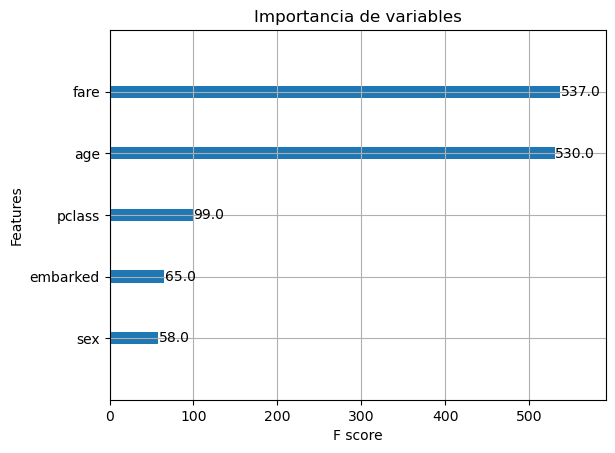

In [14]:
# --- 11. Importancia de variables ---
plt.figure(figsize=(10, 6))
plot_importance(best_clf)
plt.title("Importancia de variables")
plt.show()